# 3: Immune Infiltration Overlap Analysis

Demonstrate the usage of SpatialCells to analyse Immune cell infiltration into the tumor region

@author: Guihong Wan and Boshen Yan      
@date: Sept 8, 2023     
@last updated: Oct 6, 2023

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad

import spatialcells as spc


## Read and preprocess data

In [13]:
adata = ad.read_h5ad("../../data/MEL1_adata.h5ad")
spc.prep.setGate(adata, "KERATIN_cellRingMask", 6.4, debug=True)
spc.prep.setGate(adata, "SOX10_cellRingMask", 7.9, debug=True)
spc.prep.setGate(adata, "CD3D_cellRingMask", 7, debug=True)

KERATIN_cellRingMask_positive
False    1067400
True       43185
Name: count, dtype: int64
SOX10_cellRingMask_positive
False    566576
True     544009
Name: count, dtype: int64
CD3D_cellRingMask_positive
False    1038559
True       72026
Name: count, dtype: int64


Isolate tumor cell communities and draw region boundary as before

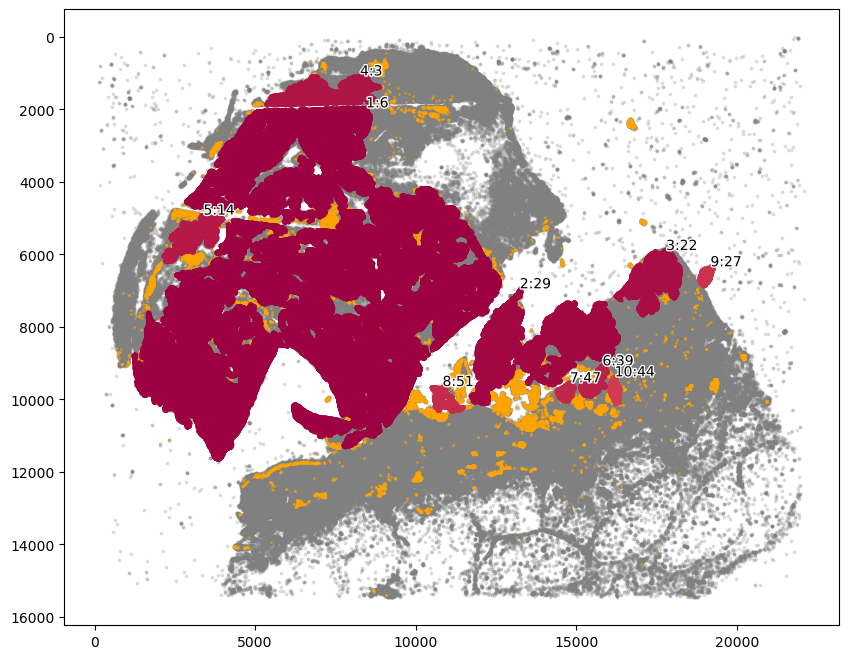

In [14]:
marker = ["SOX10_cellRingMask_positive"]
communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(adata, marker, eps=60, newcolumn=communitycolumn)
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata, ret, communitycolumn, plot_first_n_clusters=10, s=2, fontsize=10, ax=ax
)
ax.invert_yaxis()
plt.show()

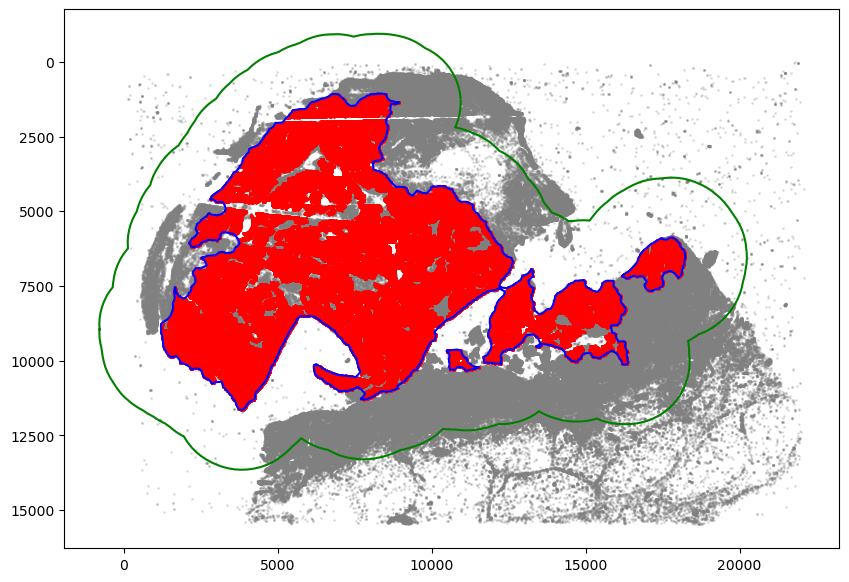

In [15]:
communityIndexList = [6, 3, 14, 51, 29, 47, 39, 44, 22]
boundary = spc.spatial.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=130
)
boundary = spc.spa.pruneSmallComponents(boundary, min_edges=50, holes_min_edges=500)
roi_boundary = spc.spa.getExtendedBoundary(boundary, offset=2000)
markersize = 1
fig, ax = plt.subplots(figsize=(10, 7))
## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")
# Bounds of points in selected commnities
spc.plt.plotBoundary(boundary, ax=ax, label="Boundary", color="b")
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="g")
ax.invert_yaxis()
plt.show()

## Assign cells to tumor region

955899it [02:32, 6267.29it/s]


Assigned points to region: Tumor


403552it [00:18, 22222.54it/s]


Assigned points to region: Tumor_ROI


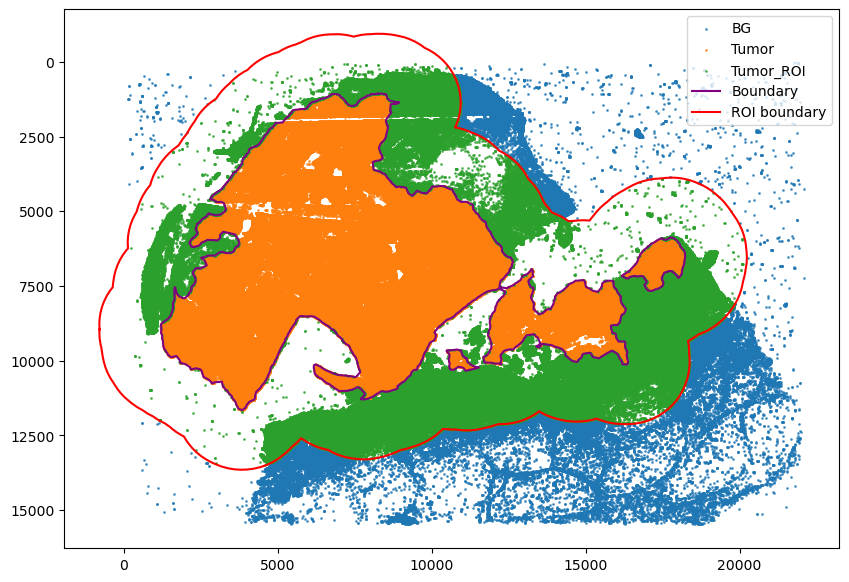

In [18]:
spc.spatial.assignPointsToRegions(
    adata,
    [boundary, roi_boundary],
    ["Tumor", "Tumor_ROI"],
    assigncolumn="region",
    default="BG",
)
point_size = 1
fig, ax = plt.subplots(figsize=(10, 7))
for region in sorted(set(adata.obs["region"])):
    tmp = adata.obs[adata.obs.region == region]
    ax.scatter(
        *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.7,
        label=region
    )
# Bounds of points in selected commnities
spc.plt.plotBoundary(boundary, ax=ax, label="Boundary", color="purple")
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="r")
plt.legend(loc="upper right")
ax.invert_yaxis()
plt.show()

Generalize cell-types based on existing phenotypes

In [19]:
def merge_pheno(row):
    if row["phenotype_large_cohort"] in [
        "T cells",
        "Cytotoxic T cells",
        "Exhausted T cells",
    ]:
        return "T cells"
    elif row["phenotype_large_cohort"] in ["Melanocytes"]:
        return "Tumor cells"
    else:
        return "Other cells"


def cell_type(row):
    if row["SOX10_cellRingMask_positive"]:
        return "SOX10+"
    elif row["CD3D_cellRingMask_positive"]:
        return "CD3D+"
    else:
        return "Other cells"


# Applying the function to create the new columns
adata.obs["pheno1"] = pd.Categorical(adata.obs.apply(merge_pheno, axis=1))
adata.obs["Cell Types"] = pd.Categorical(adata.obs.apply(cell_type, axis=1))

In [20]:
spc.msmt.getRegionComposition(adata, "pheno1")

,pheno1,cell_count,composition
0,Tumor cells,524293,0.472087
1,Other cells,516082,0.464694
2,T cells,70210,0.063219


Find immune cell infiltrated areas in the tumor ROI region

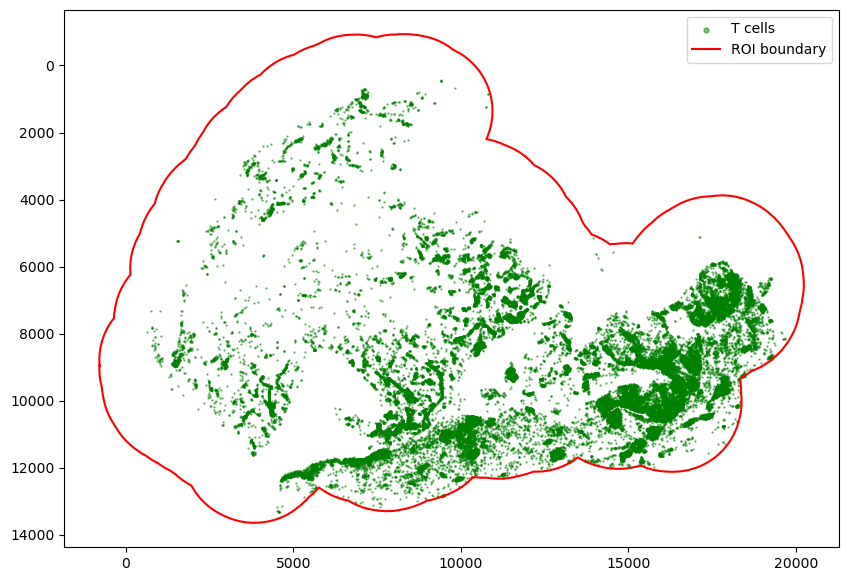

In [23]:
melano = adata[
    (adata.obs.SOX10_cellRingMask_positive) & (adata.obs.region.isin(["Tumor_ROI", "Tumor"]))
]
tcells = adata[
    (adata.obs.CD3D_cellRingMask_positive)
    & (adata.obs.region.isin(["Tumor_ROI", "Tumor"]))
]

fig, ax = plt.subplots(figsize=(10, 7))
ax.invert_yaxis()
ax.set_aspect("equal")
plt.scatter(
    tcells.obs["X_centroid"],
    tcells.obs["Y_centroid"],
    s=0.5,
    label="T cells",
    color="green",
    alpha=0.5,
)
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="r")

plt.legend(loc="upper right", markerscale=5)
plt.show()

In [25]:
tumor = adata[adata.obs.region.isin(["Tumor_ROI", "Tumor"])]
communitycolumn = "CD3D_cellRingMask_positive"
communityIndexList = [True]

immune_boundary = spc.spatial.getBoundary(
    tumor, communitycolumn, communityIndexList, alpha=130
)
immune_boundary = spc.spa.pruneSmallComponents(
    immune_boundary, min_edges=25, holes_min_edges=30, min_area=30000
)

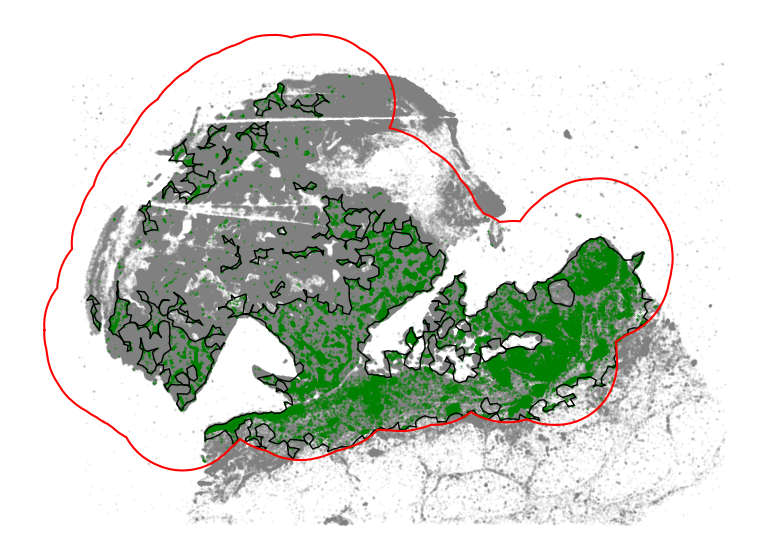

In [26]:

markersize = 0.1
fig, ax = plt.subplots(figsize=(10, 7))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)

# Points in selected commnities
xy = tumor.obs[tumor.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="green", alpha=1, label="T cells")

# Bounds of points in selected commnities
spc.plt.plotBoundary(
    immune_boundary, ax=ax, label="Immune Cell Region Boundary", color="k", linewidth=1
)

spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="r")
# ax.set_xlim(0, 20000)
# ax.set_ylim(0, 13000)
ax.invert_yaxis()
ax.set_aspect("equal")
ax.set_axis_off()
# plt.legend(loc="upper right", markerscale=5, fontsize=13.5)
# plt.savefig("immune_cell_region1.png", dpi=400)
plt.show()

In [27]:

spc.spatial.assignPointsToRegions(
    melano, [immune_boundary], ["T"], assigncolumn="tumor_isolated_region", default="F"
)

543014it [06:55, 1305.99it/s]


Assigned points to region: T


We can estimate the scale of immune infiltration by overlapping the identified immune infiltrated regions with all tumor cells.

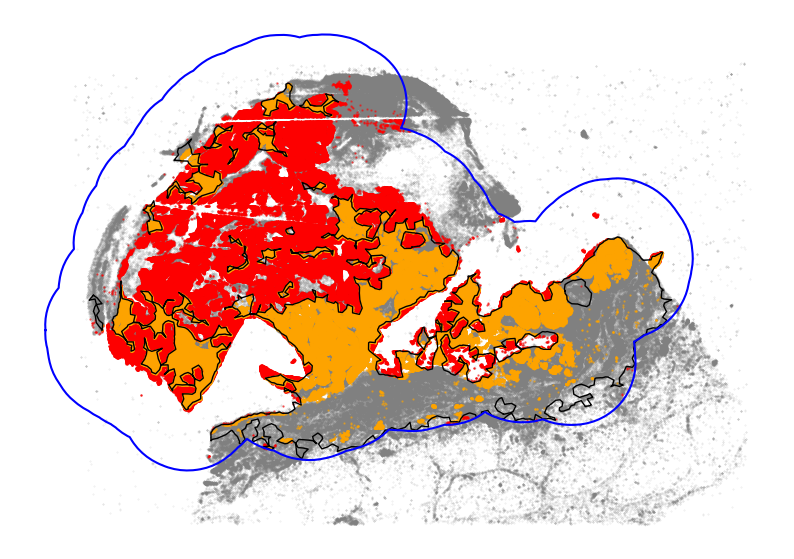

In [28]:
point_size = 0.5
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)

colors = ["red", "orange"]
labels = ["Immune-isolated Tumor Cells", "Immune-rich Tumor Cells"]
for i, region in enumerate(sorted(set(melano.obs["tumor_isolated_region"]))):
    tmp = melano.obs[melano.obs.tumor_isolated_region == region]
    ax.scatter(
        *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.5,
        color=colors[i],
        label=labels[i]
    )

# Bounds of points in selected commnities
spc.plt.plotBoundary(
    immune_boundary, ax=ax, label="Immune Cell Region Boundary", color="k", linewidth=1
)
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="b")
ax.invert_yaxis()
ax.set_axis_off()
# plt.savefig("roi_region1.png", dpi=400)
plt.show()

In [30]:
print("Percentage of tumor cells in immune-isolated regions: ")
melano.obs["tumor_isolated_region"].value_counts() / len(melano.obs)

Percentage of tumor cells in immune-isolated regions: 


tumor_isolated_region
F    0.580213
T    0.419787
Name: count, dtype: float64

We can also look at the scale of immune infiltration by comparing the area overlap between tumor regions and immune cell regions.

In [31]:
roi_area = spc.msmt.getRegionArea(roi_boundary)
tumor_area = spc.msmt.getRegionArea(boundary)
immune_area = spc.msmt.getRegionArea(immune_boundary)

tumor_immune_overlap = boundary.intersection(immune_boundary)
overlap_area = spc.msmt.getRegionArea(tumor_immune_overlap)

print(f"Area of ROI: {roi_area:.2f}")
print(f"Area of main tumor cell region: {tumor_area:.2f}")
print(f"Area of immune cell region: {immune_area}")
print(f"Area of overlap between tumor and immune cell regions: {overlap_area:.2f}")
print(
    f"Percentage of tumor region that has overlap with "
    f"immune cell region: {overlap_area / tumor_area:.3f}"
)

Area of ROI: 202741300.25
Area of main tumor cell region: 77493721.80
Area of immune cell region: 58152303.47107381
Area of overlap between tumor and immune cell regions: 29934754.20
Percentage of tumor region that has overlap with immune cell region: 0.386


Identify tumor cells that are adjacent to (<=20um) immune cells.

In [32]:
dists = spc.msmt.getMinCellTypesDistance(melano, tcells)
adata.obs.loc[
    (adata.obs.SOX10_cellRingMask_positive) & (adata.obs.region.isin(["Tumor_ROI", "Tumor"])), "dist"
] = dists

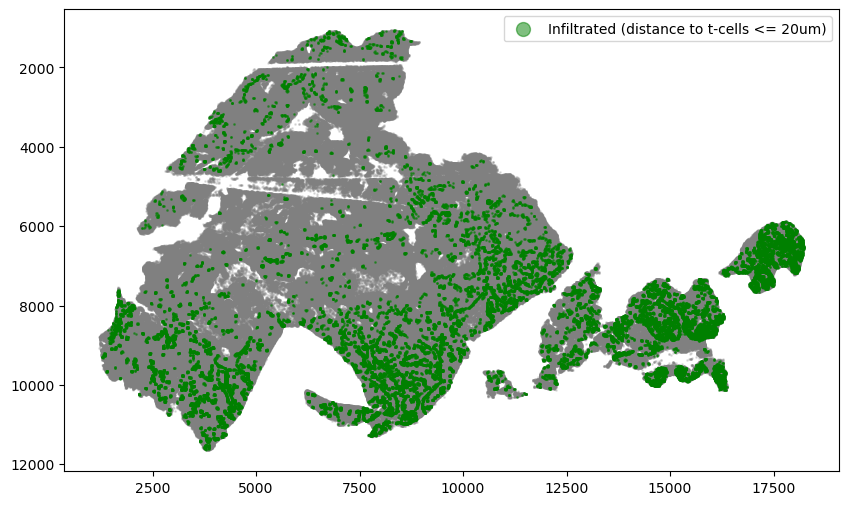

In [33]:
threshold = 20
adata.obs["dist_binned"] = adata.obs["dist"] <= threshold
infiltrated = adata.obs[
    (adata.obs.SOX10_cellRingMask_positive)
    & (adata.obs.region == "Tumor")
    & (adata.obs.dist_binned == True)
]
non_infiltrated = adata.obs[
    (adata.obs.SOX10_cellRingMask_positive)
    & (adata.obs.region == "Tumor")
    & (adata.obs.dist_binned == False)
]

fig, ax = plt.subplots(figsize=(10, 6))
ax.invert_yaxis()
region = adata.obs[(adata.obs.region == "Tumor")]
plt.scatter(region["X_centroid"], region["Y_centroid"], s=1, alpha=0.2, color="grey")
plt.scatter(
    infiltrated["X_centroid"],
    infiltrated["Y_centroid"],
    s=1,
    alpha=0.5,
    color="green",
    label=f"Infiltrated (distance to t-cells <= {threshold}um)",
)
plt.legend(markerscale=10)
plt.show()